# Import Necessary Libraries

In [ ]:
from google.colab import files

In [ ]:
files.upload()

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

In [ ]:
!kaggle datasets download -d dschettler8845/brats-2021-task1

In [ ]:
%%bash
mkdir ./kaggle
mkdir ./kaggle/Brats_2021/
unzip /content/brats-2021-task1.zip -d ./kaggle/Brats_2021/

In [ ]:
!git clone https://github.com/herolava259/gr_project.git

In [ ]:
!pip install nibabel

In [ ]:
!pip install tifffile

In [ ]:
!pip install scikit-learn

In [ ]:
%%bash

pwd
cd kaggle/Brats_2021
pwd
ls
mkdir ./train
tar -xvf ./BraTS2021_Training_Data.tar -C ./train
rm ./BraTS2021_Training_Data.tar
mkdir ./test
tar -xvf ./BraTS2021_00495.tar -C ./test
rm ./BraTS2021_00495.tar

tar -xvf ./BraTS2021_00621.tar -C ./test
rm ./BraTS2021_00621.tar.tar

cd ../..

pwd

In [ ]:
# To always ensure that the GPU is available
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical # multiclass semantic segmentation, therefore the volumes to categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler #scale values
import tensorflow as tf
import random
import os.path
!pip install split-folders
!pip3 install -U segmentation-models-3D
import splitfolders
!pip install -q -U keras-tuner

In [ ]:
# To always ensure that the GPU is available
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Define the MinMax Scaler + Mount Drive to access Dataset

* The MinMax scaler is necessary for transforming the scans' features to a range between 0 and 1

In [ ]:
scaler = MinMaxScaler()

# from google.colab import drive
# drive.mount('/content/drive')

# Load sample images and visualize



In [ ]:
DATASET_PATH = '/content/kaggle/Brats_2021/test/BraTS2021_00495_flair.nii.gz'

test_image_flair = nib.load(DATASET_PATH).get_fdata()
print(test_image_flair[156][98][78])
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)
print(test_image_flair[156][98][78])

test_image_t1 = nib.load('/content/kaggle/Brats_2021/test/BraTS2021_00495_t1.nii.gz').get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce = nib.load('/content/kaggle/Brats_2021/test/BraTS2021_00621_t1ce.nii.gz').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2 = nib.load('/content/kaggle/Brats_2021/test/BraTS2021_00495_t2.nii.gz').get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask = nib.load('/content/kaggle/Brats_2021/test/BraTS2021_00495_seg.nii.gz').get_fdata()
test_mask = test_mask.astype(np.uint8)

print(np.unique(test_mask))
# Reassign label value 4 to 3
test_mask[test_mask==4] = 3
print(np.unique(test_mask))

900.0
0.45615813482007095
[0 1 2 4]
[0 1 2 3]


In [ ]:
test_image_flair = nib.load(DATASET_PATH).get_fdata()
test_image_flair.shape

(240, 240, 155)

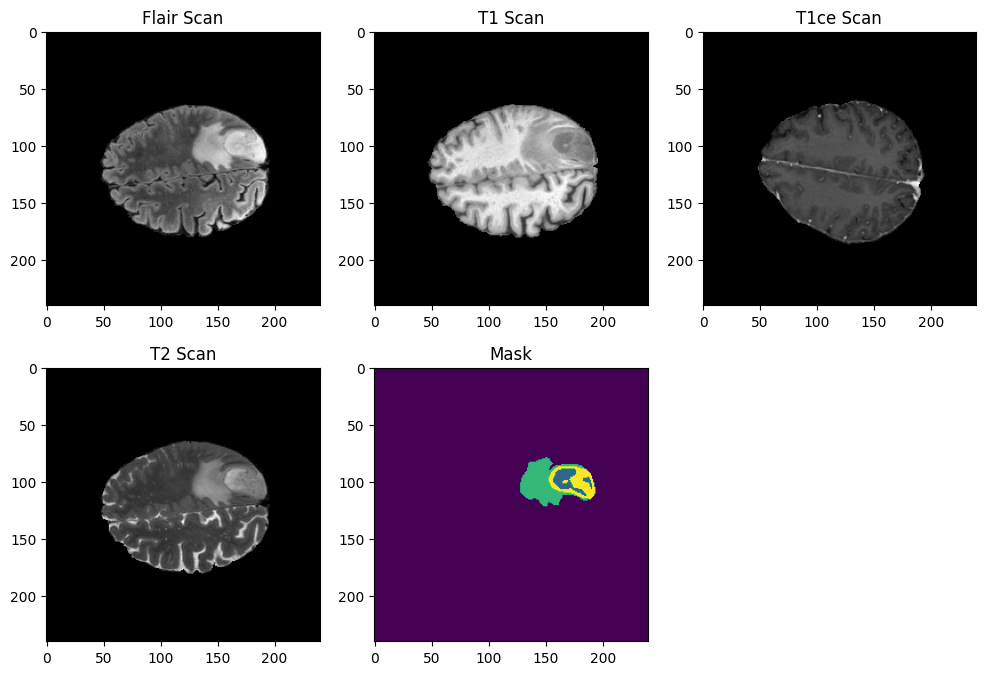

In [ ]:
n_slice = random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(test_image_flair[:, :, n_slice], cmap='gray')
plt.title('Flair Scan')

plt.subplot(232)
plt.imshow(test_image_t1[:, :, n_slice], cmap='gray')
plt.title('T1 Scan')

plt.subplot(233)
plt.imshow(test_image_t1ce[:, :, n_slice], cmap='gray')
plt.title('T1ce Scan')

plt.subplot(234)
plt.imshow(test_image_t2[:, :, n_slice], cmap='gray')
plt.title('T2 Scan')

plt.subplot(235)
plt.imshow(test_mask[:, :, n_slice])
plt.title('Mask')

plt.show()



# Data Processing: Combining the volumes of scans to one + Cropping the scans and masks

*   The numpy array is reshaped to 2D, the dimensions the scaler can take as input, the array is transformed and then reshaped back to 3D
*   Result: the feature at position [156][98][78] of the loaded FLAIR scan numpy array is transformed from 1920.0 to 0.7683...
* The three scans to be used are stacked together to forme a combined scan.
* Result: A FLAIR scan, a T1CE scan and a T2 scan, all of dimensions 255 x 255 x 155 are stacked to form a combined scan of dimensions 255 x 255 x 155 x 3
* The combined scan is cropped to 128 x 128 x 128 x 3
* Label 4 in the dataset is reassigned to label 3 resulting to a continuous list of labels: 0, 1, 2, 3

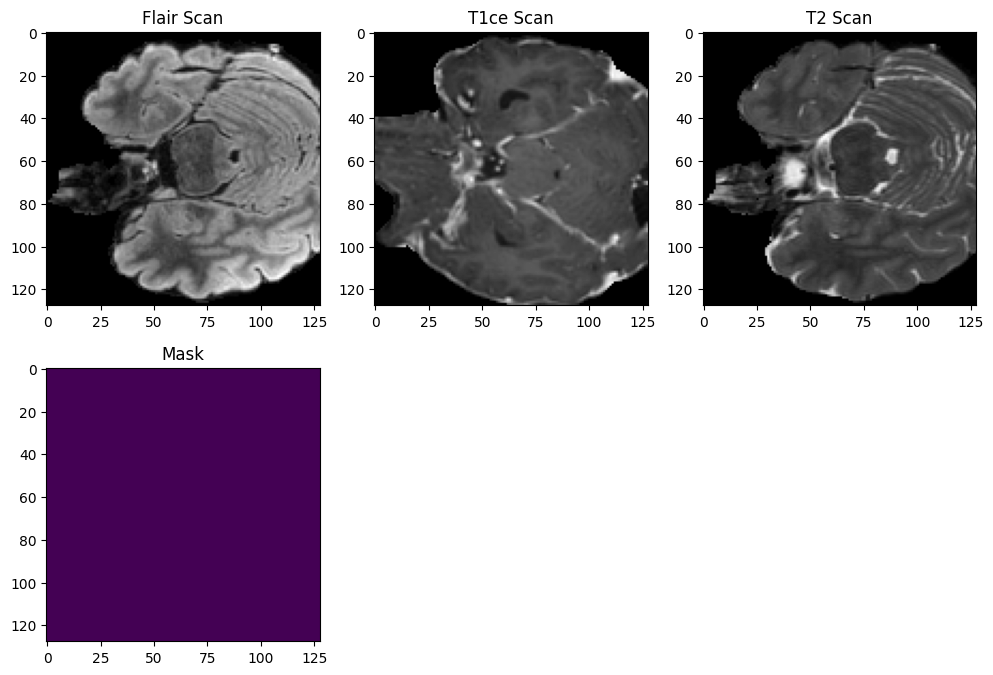

In [ ]:
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)
combined_x = combined_x[56:184, 56:184, 13:141] #crop to 128 x 128 x 128 X 3

test_mask = test_mask[56:184, 56:184, 13:141]
n_slice = random.randint(0, test_mask.shape[1])
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(combined_x[:, :, n_slice, 0], cmap='gray')
plt.title('Flair Scan')

plt.subplot(232)
plt.imshow(combined_x[:, :, n_slice, 1], cmap='gray')
plt.title('T1ce Scan')

plt.subplot(233)
plt.imshow(combined_x[:, :, n_slice, 2], cmap='gray')
plt.title('T2 Scan')

plt.subplot(234)
plt.imshow(test_mask[:, :, n_slice])
plt.title('Mask')

plt.show()

In [ ]:
from tensorflow.keras import backend as K

print(K.int_shape(test_image_flair))

print(K.int_shape(combined_x))

(240, 240, 155)
(128, 128, 128, 3)


In [ ]:
DATA_DIR = '/content/kaggle/'
RAW_DATA_FOLDER = 'Brats_2021/'
FINE_DATA_FOLDER = 'final_dataset/'

In [ ]:
def convert_and_save_npy(data_source_dir,data_dest_dir, idx = None):
  flair_list = sorted(glob.glob(data_source_dir + '*flair.nii.gz'))
  t1_list = sorted(glob.glob(data_source_dir + '*t1.nii.gz'))
  t1ce_list = sorted(glob.glob(data_source_dir + '*t1ce.nii.gz'))
  t2_list = sorted(glob.glob(data_source_dir + '*t2.nii.gz'))
  mask_list = sorted(glob.glob(data_source_dir + '*seg.nii.gz'))

  print(flair_list)


  for img in range(len(flair_list)):
    print('Now processing image and masks no: ', img)

    temp_image_flair = nib.load(flair_list[img]).get_fdata()
    temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

    temp_image_t1 = nib.load(t1_list[img]).get_fdata()
    temp_image_t1 = scaler.fit_transform(temp_image_t1.reshape(-1, temp_image_t1.shape[-1])).reshape(temp_image_t1.shape)

    temp_image_t1ce = nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

    temp_image_t2 = nib.load(t2_list[img]).get_fdata()
    temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

    temp_mask = nib.load(mask_list[img]).get_fdata()
    temp_mask = temp_mask.astype(np.uint8)
    temp_mask[temp_mask == 4] = 3

    temp_combined_images = np.stack([temp_image_flair, temp_image_t1, temp_image_t1ce, temp_image_t2], axis = 3)
    temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    val, counts = np.unique(temp_mask, return_counts=True)

    index = img if idx is None else idx
    if(1 - (counts[0]/counts.sum())) > 0.01:
      temp_mask = to_categorical(temp_mask, num_classes=4)
      np.save(data_dest_dir + 'scans/image_' + str(index) + '.npy', temp_combined_images)
      np.save(data_dest_dir + 'masks/mask_' + str(index) + '.npy', temp_mask)
      print("Saved")
    else:
      print("Not saved")

In [ ]:
convert_and_save_npy(DATA_DIR + RAW_DATA_FOLDER+'test/', DATA_DIR + FINE_DATA_FOLDER+'test/')

In [ ]:
def convert_from_folder_and_save_npy(data_source_dir,data_dest_dir):
  folder_list = os.listdir(data_source_dir)
  print(os.path.join(data_source_dir,folder_list[0]))
  i = 0
  for idx,folder in enumerate(folder_list):
    full_folder = os.path.join(data_source_dir,folder) + '/'
    convert_and_save_npy(full_folder,data_dest_dir,idx)
    i += 1
    print('.')

  print('Success sum = ',i)


In [ ]:
convert_from_folder_and_save_npy(DATA_DIR + RAW_DATA_FOLDER+'train/', DATA_DIR + FINE_DATA_FOLDER+'train/')

In [ ]:
!rm -r /content/kaggle/final_dataset

In [ ]:
!rm -r /content/kaggle/split_dataset

# Dataset Splitting: 60:20:20 for train, val and test

In [ ]:
SPLIT_DATA_FOLDER = 'split_dataset/'
!mkdir {DATA_DIR + SPLIT_DATA_FOLDER}
input_folder =  DATA_DIR + FINE_DATA_FOLDER + 'train/'
output_folder = DATA_DIR + 'split_dataset/'
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.6, .2, .2), group_prefix=None)

# Data Generator




In [ ]:
import os
import numpy as np

def load_img(img_dir, img_list):
  images=[]
  for i, image_name in enumerate(img_list):
    if(image_name.split('.')[1] == 'npy'):
      image = np.load(img_dir + image_name)
      images.append(image)
    images = np.array(images)
    return images

def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
  L = len(img_list)
  # keras needs the generator infinite, so use while True
  while True:
    batch_start = 0
    batch_end = batch_size

    while batch_start < L:
      limit = min(batch_end, L)
      X = load_img(img_dir, img_list[batch_start:limit])
      Y = load_img(mask_dir, mask_list[batch_start:limit])

      yield(X, Y) # a tuple with two numpy arrays with batch_size samples

      batch_start += batch_size
      batch_end += batch_size


# Test the generator
TRAIN_DATASET_PATH = ''
train_img_dir = TRAIN_DATASET_PATH + 'scans/'
train_mask_dir = TRAIN_DATASET_PATH + 'masks/'

train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

# Verify generator - In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0, img.shape[0]-1)

test_img = img[img_num]
test_mask = msk[img_num]
test_mask = np.argmax(test_mask, axis=3)

n_slice = random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12,8))

plt.subplot(221)
plt.imshow(test_img[:, :, n_slice, 0], cmap='gray')
plt.title('Flair Scan')

plt.subplot(222)
plt.imshow(test_img[:, :, n_slice, 1], cmap='gray')
plt.title('T1ce Scan')

plt.subplot(223)
plt.imshow(test_img[:, :, n_slice, 2], cmap='gray')
plt.title('T2 Scan')

plt.subplot(224)
plt.imshow(test_mask[:, :, n_slice])
plt.title('Mask')

plt.show()

# Define image generators for training, validation and testing

In [ ]:
DATASET_PATH = ''
train_img_dir = DATASET_PATH + 'train/scans/'
train_mask_dir = DATASET_PATH + 'train/masks/'

val_img_dir = DATASET_PATH + 'val/scans/'
val_mask_dir = DATASET_PATH + 'val/masks/'

test_img_dir = DATASET_PATH + 'test/scans/'
test_mask_dir = DATASET_PATH + 'test/masks/'

train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

test_img_list = os.listdir(test_img_dir)
test_mask_list = os.listdir(test_mask_dir)

batch_size = 2
train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

test_img_datagen = imageLoader(test_img_dir, test_img_list,
                                test_mask_dir, test_mask_list, batch_size)


# Losses and metrics
* These losses and metrics best handle the problem of class imbalance
* Used: dice_coef as a metric, tversky_loss as a loss

In [ ]:
import tensorflow.keras.backend as K


def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) +
                                           smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg +
                                  (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

# Define loss, metrics and optimizer to be used for training

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, Activation, add, concatenate, Conv3DTranspose, BatchNormalization, Dropout, UpSampling3D, multiply
from tensorflow.keras.optimizers import Adam
from keras import layers

kernel_initializer = 'he_uniform'

import segmentation_models_3D as sm

metrics = [dice_coef]

LR = 0.0001
optim = Adam(LR)

steps_per_epoch = len(train_img_list) // batch_size
val_steps_per_epoch = len(val_img_list) // batch_size

# 3D UNet Model

In [ ]:
def UNet(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))

  # Downsampling
  c1 = Conv3D(filters = 16, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(inputs)
  c1 = Dropout(0.1)(c1)
  c1 = Conv3D(filters = 16, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
  p1 = MaxPooling3D((2, 2, 2))(c1)

  c2 = Conv3D(filters = 32, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
  c2 = Dropout(0.1)(c2)
  c2 = Conv3D(filters = 32, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
  p2 = MaxPooling3D((2, 2, 2))(c2)

  c3 = Conv3D(filters = 64, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv3D(filters = 64, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
  p3 = MaxPooling3D((2, 2, 2))(c3)

  c4 = Conv3D(filters = 128, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv3D(filters = 128, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
  p4 = MaxPooling3D((2, 2, 2))(c4)

  c5 = Conv3D(filters = 256, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv3D(filters = 256, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

  # Upsampling part
  u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv3D(filters = 128, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv3D(filters = 128, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

  u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv3D(filters = 64, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv3D(filters = 64, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

  u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv3D(filters = 32, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
  c8 = Dropout(0.1)(c8)
  c8 = Conv3D(filters = 32, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

  u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1])
  c9 = Conv3D(filters = 16, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
  c9 = Dropout(0.1)(c9)
  c9 = Conv3D(filters = 16, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

  outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  model.summary()

  return model

# Test the working of the 3D UNet model

In [ ]:
from tensorflow.keras.optimizers import Adam
model = UNet(IMG_HEIGHT = 128,
              IMG_WIDTH = 128,
              IMG_DEPTH = 128,
              IMG_CHANNELS = 3,
              num_classes = 4)
LR = 0.0001
optim = Adam(LR)
metrics = [dice_coef]
model.compile(optimizer = optim, loss = tversky_loss, metrics = metrics)

print(model.summary)

print(model.input_shape)
print(model.output_shape)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_134 (Conv3D)            (None, 128, 128, 12  1312        ['input_7[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_54 (Dropout)           (None, 128, 128, 12  0           ['conv3d_134[0][0]']             
                                8, 16)                                                      

In [ ]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

model = UNet(IMG_HEIGHT = 128,
              IMG_WIDTH = 128,
              IMG_DEPTH = 128,
              IMG_CHANNELS = 3,
              num_classes = 4)

model.compile(optimizer = optim, loss = tversky_loss, metrics = metrics)

print(model.summary)

print(model.input_shape)
print(model.output_shape)

# 3D Attention UNet Model

In [ ]:
from keras.layers.core.activation import Activation
from tensorflow.keras import backend as K
from keras.layers import LeakyReLU

def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 128,128,3), lambda will return a tensor of shape
    #(None, 128,128,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=4),
                          arguments={'repnum': rep})(tensor)

def attention_block(x, gating, inter_shape):
  shape_x = K.int_shape(x)
  shape_g = K.int_shape(gating)

  # Getting the gating signal to the same number of filters as the inter_shape
  phi_g = Conv3D(filters=inter_shape, kernel_size=1, strides=1, padding='same')(gating)

  # Geting the x signal to the same shape as the gating signal
  theta_x = Conv3D(filters=inter_shape, kernel_size=3, strides=(
      shape_x[1] // shape_g[1],
      shape_x[2] // shape_g[2],
      shape_x[3] // shape_g[3]
  ), padding='same')(x)
  shape_theta_x = K.int_shape(theta_x)

  print(shape_theta_x, shape_g)

  # Elemet-wise addition of the gating and x signals
  xg_sum = add([phi_g, theta_x])
  xg_sum = Activation('relu')(xg_sum)

  # 1x1x1 convolution
  psi = Conv3D(filters=1, kernel_size=1, padding='same')(xg_sum)
  sigmoid_psi = Activation('sigmoid')(psi)
  shape_sigmoid = K.int_shape(sigmoid_psi)

  # Upsampling psi back to the original dimensions of x signal to enable
  # element-wise multiplication with the signal

  upsampled_sigmoid_psi = UpSampling3D(size=(
      shape_x[1] // shape_sigmoid[1],
      shape_x[2] // shape_sigmoid[2],
      shape_x[3] // shape_sigmoid[3]
  ))(sigmoid_psi)

  # Expand the filter axis to the number of filters in the original x signal
  upsampled_sigmoid_psi = repeat_elem(upsampled_sigmoid_psi, shape_x[4])

  # Element-wise multiplication of attention coefficients back onto original x signal
  attention_coeffs = multiply([upsampled_sigmoid_psi, x])

  # Final 1x1x1 convolution to consolidate attention signal to original  x dimensions
  output = Conv3D(filters=shape_x[3], kernel_size=1, strides=1, padding='same')(attention_coeffs)
  output = BatchNormalization()(output)
  return output


# Gating signal
def gating_signal(input, output_size, batch_norm=False):
  # Resize the down layer feature map into the same dimensions as the up layer feature map using 1x1 conv
  # Return: the gating feature map with the same dimension of the up layer feature map
  x = Conv3D(output_size, (1, 1, 1), padding='same')(input)
  if batch_norm:
    x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x


# Attention UNet
def attention_unet(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes, batch_norm = True):
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
  FILTER_NUM = 64 #
  FILTER_SIZE = 3 #
  UP_SAMPLING_SIZE = 2 #

  c1 = Conv3D(filters = 16, kernel_size = 3, strides = 1, activation=LeakyReLU(alpha=0.1), kernel_initializer=kernel_initializer, padding='same')(inputs)
  c1 = Dropout(0.1)(c1)
  c1 = Conv3D(filters = 16, kernel_size = 3, strides = 1, activation=LeakyReLU(alpha=0.1), kernel_initializer=kernel_initializer, padding='same')(c1)
  p1 = MaxPooling3D((2, 2, 2))(c1)

  c2 = Conv3D(filters = 32, kernel_size = 3, strides = 1, activation=LeakyReLU(alpha=0.1), kernel_initializer=kernel_initializer, padding='same')(p1)
  c2 = Dropout(0.1)(c2)
  c2 = Conv3D(filters = 32, kernel_size = 3, strides = 1, activation=LeakyReLU(alpha=0.1), kernel_initializer=kernel_initializer, padding='same')(c2)
  p2 = MaxPooling3D((2, 2, 2))(c2)

  c3 = Conv3D(filters = 64, kernel_size = 3, strides = 1, activation=LeakyReLU(alpha=0.1), kernel_initializer=kernel_initializer, padding='same')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv3D(filters = 64, kernel_size = 3, strides = 1, activation=LeakyReLU(alpha=0.1), kernel_initializer=kernel_initializer, padding='same')(c3)
  p3 = MaxPooling3D((2, 2, 2))(c3)

  c4 = Conv3D(filters = 128, kernel_size = 3, strides = 1, activation=LeakyReLU(alpha=0.1), kernel_initializer=kernel_initializer, padding='same')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv3D(filters = 128, kernel_size = 3, strides = 1, activation=LeakyReLU(alpha=0.1), kernel_initializer=kernel_initializer, padding='same')(c4)
  p4 = MaxPooling3D((2, 2, 2))(c4)

  c5 = Conv3D(filters = 256, kernel_size = 3, strides = 1, activation=LeakyReLU(alpha=0.1), kernel_initializer=kernel_initializer, padding='same')(p4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv3D(filters = 256, kernel_size = 3, strides = 1, activation=LeakyReLU(alpha=0.1), kernel_initializer=kernel_initializer, padding='same')(c5)


  gating_6 = gating_signal(c5, 128, batch_norm)
  att_6 = attention_block(c4, gating_6, 128)
  u6 = UpSampling3D((2, 2, 2), data_format='channels_last')(c5)
  u6 = concatenate([u6, att_6])
  c6 = Conv3D(filters = 128, kernel_size = 3, strides = 1, activation=LeakyReLU(alpha=0.1), kernel_initializer=kernel_initializer, padding='same')(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv3D(filters = 128, kernel_size = 3, strides = 1, activation=LeakyReLU(alpha=0.1), kernel_initializer=kernel_initializer, padding='same')(c6)

  gating_7 = gating_signal(c6, 64, batch_norm)
  att_7 = attention_block(c3, gating_6, 64)
  u7 = UpSampling3D((2, 2, 2), data_format='channels_last')(c6)
  u7 = concatenate([u7, att_7])
  c7 = Conv3D(filters = 64, kernel_size = 3, strides = 1, activation=LeakyReLU(alpha=0.1), kernel_initializer=kernel_initializer, padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv3D(filters = 64, kernel_size = 3, strides = 1, activation=LeakyReLU(alpha=0.1), kernel_initializer=kernel_initializer, padding='same')(c7)

  gating_8 = gating_signal(c7, 64, batch_norm)
  att_8 = attention_block(c2, gating_6, 64)
  u8 = UpSampling3D((2, 2, 2), data_format='channels_last')(c7)
  u8 = concatenate([u8, att_8])
  c8 = Conv3D(filters = 32, kernel_size = 3, strides = 1, activation=LeakyReLU(alpha=0.1), kernel_initializer=kernel_initializer, padding='same')(u8)
  c8 = Dropout(0.1)(c8)
  c8 = Conv3D(filters = 32, kernel_size = 3, strides = 1, activation=LeakyReLU(alpha=0.1), kernel_initializer=kernel_initializer, padding='same')(c8)

  gating_9 = gating_signal(c8, 64, batch_norm)
  att_9 = attention_block(c1, gating_6, 64)
  u9 = UpSampling3D((2, 2, 2), data_format='channels_last')(c8)
  u9 = concatenate([u9, att_9])
  c9 = Conv3D(filters = 16, kernel_size = 3, strides = 1, activation=LeakyReLU(alpha=0.1), kernel_initializer=kernel_initializer, padding='same')(u9)
  c9 = Dropout(0.1)(c9)
  c9 = Conv3D(filters = 16, kernel_size = 3, strides = 1, activation=LeakyReLU(alpha=0.1), kernel_initializer=kernel_initializer, padding='same')(c9)

  outputs = Conv3D(num_classes, (1, 1, 1))(c9)
  outputs = BatchNormalization()(outputs)
  outputs = Activation('softmax')(outputs)

  model = Model(inputs=[inputs], outputs=[outputs], name="Attention_UNet")
  model.summary()

  return model

In [ ]:

model = attention_unet(IMG_HEIGHT = 128,
              IMG_WIDTH = 128,
              IMG_DEPTH = 128,
              IMG_CHANNELS = 3,
              num_classes = 4)

model.compile(optimizer = optim, loss = tversky_loss, metrics = metrics)

print(model.summary)

print(model.input_shape)
print(model.output_shape)

# Test the working of a 3D Attention UNet Model

In [ ]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

model = attention_unet(IMG_HEIGHT = 128,
              IMG_WIDTH = 128,
              IMG_DEPTH = 128,
              IMG_CHANNELS = 3,
              num_classes = 4)

model.compile(optimizer = optim, loss = tversky_loss, metrics = metrics)

print(model.summary)

print(model.input_shape)
print(model.output_shape)

# Fit the Model

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TerminateOnNaN

checkpoint_path = ''
log_path = ''

callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1,
                      monitor='val_loss',
                      patience=4,
                      min_lr=0.0001,
                      verbose=1,
                      mode='min'),
    ModelCheckpoint(checkpoint_path,
                    monitor='val_loss',
                    mode='min',
                    verbose=0,
                    save_best_only=True),
    CSVLogger(log_path, separator=',', append=True),
    TerminateOnNaN()
]

history = model.fit(train_img_datagen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=100,
                    verbose=1,
                    validation_data=val_img_datagen,
                    validation_steps=val_steps_per_epoch,
                    callbacks=callbacks
                    )

history_callback = np.save('', history.history)

# Load Model for more training

In [ ]:
import tensorflow.keras.models as load
import keras
model = load.load_model('', custom_objects={
    'tversky_loss': tversky_loss,
    'dice_coef': dice_coef
})

checkpoint_path = ''
log_path = ''

callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1,
                      monitor='val_loss',
                      patience=4,
                      min_lr=0.0001,
                      verbose=1,
                      mode='min'),
    ModelCheckpoint(checkpoint_path,
                    monitor='val_loss',
                    mode='min',
                    verbose=0,
                    save_best_only=True),
    CSVLogger(log_path, separator=',', append=True),
    TerminateOnNaN()
]

history = model.fit(train_img_datagen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=100,
                    verbose=1,
                    validation_data=val_img_datagen,
                    validation_steps=val_steps_per_epoch,
                    callbacks=callbacks
                    )

history_callback = np.save('', history.history)

# Plot the training and validation loss (tversky) and dice coefficient (metric) at each epoch

In [ ]:
history = np.load('',allow_pickle='TRUE').item()

print(history)
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history['dice_coef']
val_acc = history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Trainign and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Model Evaluation

In [ ]:
from tensorflow.keras.models import load_model
my_model = load_model('', custom_objects={
    'tversky_loss': tversky_loss,
    'dice_coef': dice_coef},
    compile = True)

# Verify IoU on a batch of images from the test dataset
batch_size = 8
test_img_datagen = imageLoader(val_img_dir, val_img_list,
                               val_mask_dir, val_mask_list, batch_size)

test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)

results = my_model.evaluate(test_image_batch, test_mask_batch, batch_size=batch_size)
print("test acc, test loss:", results)

# Predict on a test scan

In [ ]:
from tensorflow.keras.models import load_model
my_model = load_model('', compile=False)

img_num = 53
test_scan = np.load('' + str(img_num) + '.npy')

test_mask = np.load('' + str(img_num) + '.npy')
test_mask_argmax = np.argmax(test_mask, axis = 3)

test_scan_input = np.expand_dims(test_scan, axis = 0)
test_prediction = my_model.predict(test_scan_input)
test_prediction_argmax = np.argmax(test_prediction, axis = 4)[0, :, :, :]

In [ ]:
# n_slice = 55
n_slice = random.randint(0, test_mask_argmax.shape[2])

plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(test_scan[:, :, n_slice, 1], cmap='gray')
plt.title('Testing Scan')

plt.subplot(232)
plt.imshow(test_mask_argmax[:, :, n_slice])
plt.title('Testing Label')

plt.subplot(235)
plt.imshow(test_prediction_argmax[:, :, n_slice])
plt.title('Prediction on test image')

plt.show()